## Model 2: Logistic Regression,  data2 : fraud2_after_subset dataset

Using the data where the transaction amount corresponds to the difference between before & after balance

Removed all the rows where the transaction amount mismatched the balance

Shape: (2423175, 12) which 38.1% of original dataset

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix


In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [3]:
df = pd.read_csv("fraud2_after_subset.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
3,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.00,0.00,0,0
4,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2423170,718,CASH_IN,188888.89,C1459052107,51838.0,240726.89,C1955750585,0.00,0.00,0,0
2423171,718,CASH_IN,27919.60,C562982749,2413.0,30332.60,C240654881,512791.59,484871.98,0,0
2423172,718,CASH_IN,78988.38,C886862695,204464.0,283452.38,C262804200,108724.19,29735.81,0,0
2423173,718,CASH_IN,18000.26,C50108853,63409.0,81409.26,C204102272,28088.61,10088.34,0,0


In [4]:
df.shape

(2423175, 11)

In [5]:
## separating variables
num_col=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
cat_col = ['type','nameOrig','nameDest']
encoded_col = ['isFraud','isFlaggedFraud']

## Cleaning the dataset

In [6]:
##dropping 'nameOrig' and 'nameDest' as they are ID's of the sender and recipient which are not useful for the model
df.drop(['nameOrig','nameDest'],axis=1,inplace=True)

In [7]:
## replacing outliers with median 

for col in num_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    UB = Q3 + 1.5* IQR #1280.25 upper bound for outliers
    LB = Q1 - 1.5* IQR #lowe upper bound for outliers
    df[col] = np.where(df[col] > UB, int(df[col].median()),df[col])
    df[col] = np.where(df[col] < LB, int(df[col].median()),df[col])
    #df.drop(df[df[col] < LB].index, inplace=True)
    #df.drop(df[df[col] > UB].index, inplace=True)

In [8]:
## One-hot encoding on 'type' column to turn it into numerical values, instead of label encoding 
## too avoid the model misunderstand the data to be in some kind of order, 0 < 1 <2
df=pd.get_dummies(data=df,columns=['type'],drop_first=True)

## changing booleans of encoded 'type' data to 0/1
zero_one = {False:0, True:1}
type_encoded = ['type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER']
for i in type_encoded:
    df[i] = df[i].map(zero_one)

In [9]:
## moving target variable'isFraud' as the last column to split easier intp train, split later on
df = df[ [ col for col in df.columns if col != 'isFraud' ] + ['isFraud'] ]

In [10]:
# We are using RobustScaler to scale down the numerical features as RobustScaler is less prone to outliers
scale = RobustScaler()
for feature in num_col:
    df[feature]=scale.fit_transform(df[feature].values.reshape(-1, 1))
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,-1.346591,-0.237821,0.570101,-0.106390,-0.082361,0.0,0,0,0,1,0,0
1,-1.346591,-0.301799,-0.740979,-0.911883,-0.082361,0.0,0,0,0,1,0,0
2,-1.346591,-0.223153,-0.562176,-0.851855,-0.082361,0.0,0,0,0,1,0,0
3,-1.346591,-0.254041,-0.453811,-0.759500,-0.082361,0.0,0,0,0,1,0,0
4,-1.346591,-0.259736,0.685097,-0.016124,-0.082361,0.0,0,0,0,1,0,0


In [11]:
## the cleaned data
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,-1.346591,-0.237821,0.570101,-0.106390,-0.082361,0.000000,0,0,0,1,0,0
1,-1.346591,-0.301799,-0.740979,-0.911883,-0.082361,0.000000,0,0,0,1,0,0
2,-1.346591,-0.223153,-0.562176,-0.851855,-0.082361,0.000000,0,0,0,1,0,0
3,-1.346591,-0.254041,-0.453811,-0.759500,-0.082361,0.000000,0,0,0,1,0,0
4,-1.346591,-0.259736,0.685097,-0.016124,-0.082361,0.000000,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2423170,0.000000,1.198501,-0.471616,0.353375,-0.082361,0.000000,0,0,0,0,0,0
2423171,0.000000,-0.092785,-0.906846,-0.849302,2.090179,3.765836,0,0,0,0,0,0
2423172,0.000000,0.316886,0.872389,0.597607,0.378270,0.230948,0,0,0,0,0,0
2423173,0.000000,-0.172357,-0.369723,-0.557332,0.036642,0.078353,0,0,0,0,0,0


## Split data intro train and test

In [12]:
## select dep and indep 
X = df.iloc[:,:-1].values 
y = df.iloc[:,-1].values

# spplit into train test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=32) 

## Model logistic regression

In [13]:
## build logistic regression model: will take a while since we have over 6million records
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

## make prediction
y_pred = log_reg.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluation

In [14]:
# check accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9982130882003982


In [15]:
## classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    483012
           1       0.89      0.53      0.67      1623

    accuracy                           1.00    484635
   macro avg       0.94      0.77      0.83    484635
weighted avg       1.00      1.00      1.00    484635



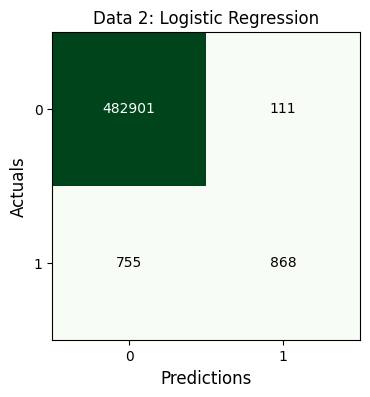

In [16]:
#confusion matrix

logr_conf_mat = confusion_matrix(y_test, y_pred)
logr_conf_mat

fig, ax = plot_confusion_matrix(conf_mat = logr_conf_mat , figsize = (4,4), cmap = 'Greens')
plt.xlabel('Predictions', fontsize = 12 )
plt.ylabel('Actuals', fontsize = 12 )
plt.title('Data 2: Logistic Regression', fontsize = 12 )
plt.show()

AUC: 0.767291


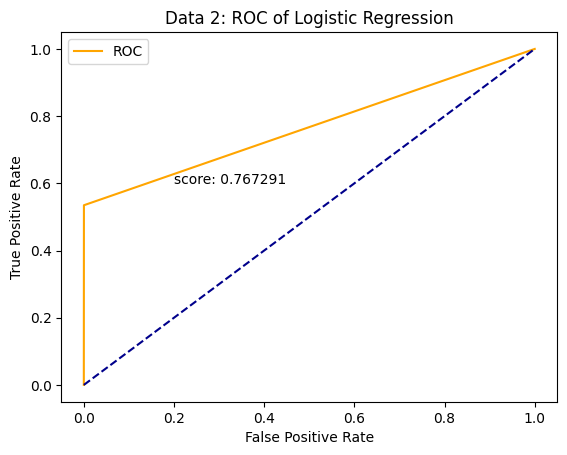

In [17]:
## Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %f' %auc)


fpr, tpr = roc_curve(y_test, y_pred)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Data 2: ROC of Logistic Regression')
plt.text(y= 0.6, x=0.2, s=f'score: {round(auc,6)}')
plt.legend()
plt.show()

## Conclusion


Although the accuracy is at 99.8%, from the confusion matrix, this model is no better than the current system that the bank is using and the original dataset's model.
The model can start to recognise more fraud transactions correclty but still makes mistakes with FP+FN almost equal TP.
Due to the imblance dataset, the model recognises non-fraud transactions the most.

The ROC at 0.76 shows that this model is better than the original dataset's model.